In [ ]:
import pandas as pd
import pysentiment2 as ps  # <--- Nouvelle librairie
from tqdm import tqdm

# 1. Configuration
FILE_PATH = '../data/headlines.csv'
START_DATE = '2005-01-01'  
END_DATE = '2008-12-31'

# 2. Chargement & Nettoyage (Ton code existant)
df_large = pd.read_csv(FILE_PATH)

col_text = [c for c in df_large.columns if 'title' in c.lower() or 'headline' in c.lower()][0]
col_date = [c for c in df_large.columns if 'date' in c.lower() or 'published' in c.lower()][0]

# Conversion date
df_large[col_date] = pd.to_datetime(df_large[col_date].astype(str), format='%Y%m%d', errors='coerce')
df_large = df_large.dropna(subset=[col_date])

# Filtre temporel
mask = (df_large[col_date] >= START_DATE) & (df_large[col_date] <= END_DATE)
df_filtered = df_large.loc[mask].copy()

print(f"Lignes trouvées : {len(df_filtered)}")

# 3. Initialisation du moteur Loughran-McDonald
lm = ps.LM()  # Charge le dictionnaire Finance

def get_lm_score(text):
    # LM a besoin de tokens (mots séparés), pas de phrases brutes
    tokens = lm.tokenize(str(text))
    score = lm.get_score(tokens)
    # Le score retourné est un dictionnaire : {'Positive': x, 'Negative': y, 'Polarity': z, ...}
    # Polarity = (Pos - Neg) / (Pos + Neg). 
    return score['Polarity']

# 4. Calcul (Si données présentes)
if len(df_filtered) > 0:
    tqdm.pandas()
    print("Calcul du sentiment Loughran-McDonald (Finance Specific)...")
    
    # Attention : C'est un peu plus lent que VADER car la tokenisation est plus stricte
    df_filtered['sentiment_score'] = df_filtered[col_text].progress_apply(get_lm_score)
    
    # 5. Agrégation
    df_filtered['date_only'] = df_filtered[col_date].dt.date
    daily_agg = df_filtered.groupby('date_only')['sentiment_score'].agg(['mean', 'count']).reset_index()
    
    # 6. Sauvegarde
    daily_agg.to_csv('../data/daily_sentiment_lm_final.csv', index=False)
    print("Fichier daily_sentiment_lm_final.csv généré !")
    
else:
    print("Aucune donnée trouvée après filtrage.")

Lignes trouvées : 370399
Calcul du sentiment Loughran-McDonald (Finance Specific)...


100%|██████████| 370399/370399 [00:18<00:00, 19546.65it/s]


Fichier daily_sentiment_lm_final.csv généré !


Colonnes Sentiment : Index(['date_only', 'mean', 'count'], dtype='object')
Colonnes Finance : Index(['DATE', 'Volatility'], dtype='object')


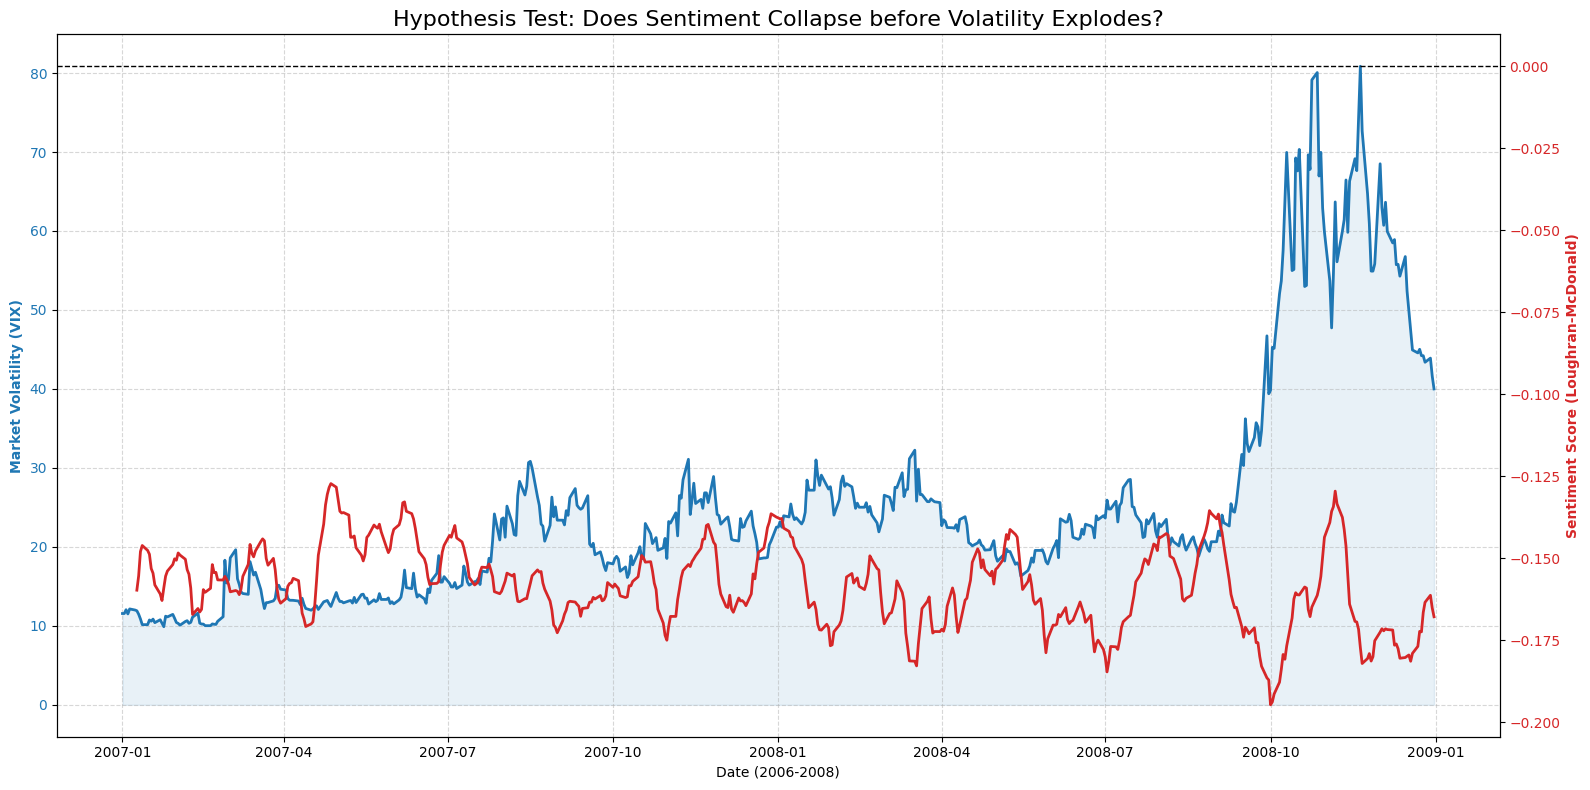

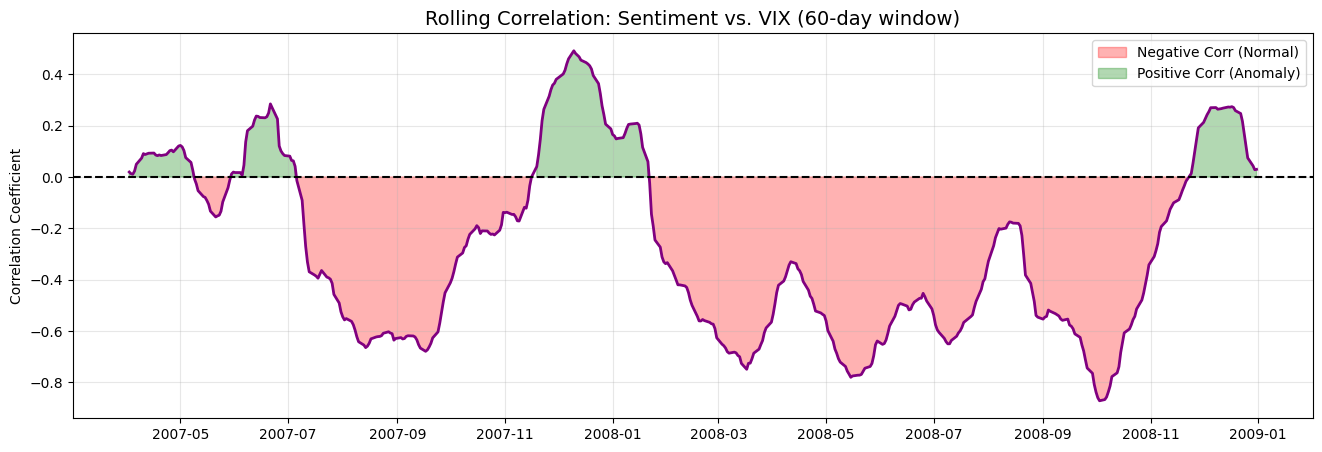

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Chargement des données
# On suppose que tes fichiers sont bien générés
df_sent = pd.read_csv('../data/daily_sentiment_lm_final.csv')
df_fine = pd.read_csv('../data/financial_data_VIX.csv') # Ou 'financial_data_VIX.csv' selon comment tu l'as nommé

# --- DEBUG : AFFICHE LES COLONNES POUR ÊTRE SÛR ---
print("Colonnes Sentiment :", df_sent.columns)
print("Colonnes Finance :", df_fine.columns)
# Regarde si c'est 'Date', 'DATE', ou si la date est dans l'index.

# 2. Nettoyage et Conversion
# A. Sentiment
df_sent['date_only'] = pd.to_datetime(df_sent['date_only'])

# B. Finance (CORRECTION ICI)
# FRED nomme souvent la colonne 'DATE'. Si ton CSV a 'Date', remets 'Date'.
# On utilise une astuce : on renomme la colonne date en 'Date' pour standardiser.
col_date_fin = 'DATE' if 'DATE' in df_fine.columns else 'Date'

# On convertit
df_fine[col_date_fin] = pd.to_datetime(df_fine[col_date_fin]).dt.tz_localize(None)
df_fine = df_fine.sort_values(col_date_fin)

# 3. Fusion des deux mondes
# On utilise la variable 'col_date_fin' pour ne plus avoir d'erreur
df_plot = pd.merge(df_fine, df_sent, left_on=col_date_fin, right_on='date_only', how='inner')

# On renomme la colonne date finale pour simplifier la suite
df_plot = df_plot.rename(columns={col_date_fin: 'Date'})

# 4. Lissage (Smoothing)
df_plot['sentiment_smooth'] = df_plot['mean'].rolling(window=7).mean()

# 5. Création du graphique
fig, ax1 = plt.subplots(figsize=(16, 8))

# --- Axe 1 : Volatilité (VIX) ---
color_vol = '#1f77b4' # Bleu
ax1.set_xlabel('Date (2006-2008)')
ax1.set_ylabel('Market Volatility (VIX)', color=color_vol, fontweight='bold')
# On vérifie si la colonne s'appelle 'Volatility' ou 'Close' ou 'VIXCLS'
col_vol = 'Volatility' if 'Volatility' in df_plot.columns else df_plot.columns[1] # Prends la 2eme colonne par défaut

ax1.plot(df_plot['Date'], df_plot[col_vol], color=color_vol, lw=2, label='VIX (Fear Index)')
ax1.fill_between(df_plot['Date'], df_plot[col_vol], alpha=0.1, color=color_vol)
ax1.tick_params(axis='y', labelcolor=color_vol)

# --- Axe 2 : Sentiment (NLP) ---
ax2 = ax1.twinx()
color_sent = '#d62728' # Rouge
ax2.set_ylabel('Sentiment Score (Loughran-McDonald)', color=color_sent, fontweight='bold')
ax2.plot(df_plot['Date'], df_plot['sentiment_smooth'], color=color_sent, lw=2, label='News Sentiment (7d Avg)')
ax2.axhline(0, color='black', lw=1, ls='--')
ax2.tick_params(axis='y', labelcolor=color_sent)

plt.title('Hypothesis Test: Does Sentiment Collapse before Volatility Explodes?', fontsize=16)
ax1.grid(True, linestyle='--', alpha=0.5)
fig.tight_layout()
plt.show()

# --- CORRÉLATION GLISSANTE ---
# On utilise la colonne de volatilité détectée automatiquement
df_plot['rolling_corr'] = df_plot['sentiment_smooth'].rolling(window=60).corr(df_plot[col_vol])

plt.figure(figsize=(16, 5))
plt.plot(df_plot['Date'], df_plot['rolling_corr'], color='purple', lw=2)
plt.axhline(0, color='black', linestyle='--')
# Remplissage conditionnel
plt.fill_between(df_plot['Date'], df_plot['rolling_corr'], 0, 
                 where=(df_plot['rolling_corr'] < 0), color='red', alpha=0.3, label='Negative Corr (Normal)')
plt.fill_between(df_plot['Date'], df_plot['rolling_corr'], 0, 
                 where=(df_plot['rolling_corr'] > 0), color='green', alpha=0.3, label='Positive Corr (Anomaly)')

plt.title('Rolling Correlation: Sentiment vs. VIX (60-day window)', fontsize=14)
plt.ylabel('Correlation Coefficient')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1. Chargement & Préparation
df_sent = pd.read_csv('../data/daily_sentiment_lm_final.csv')
df_fine = pd.read_csv('../data/financial_data_KBE.csv')

# Conversion dates
df_sent['date_only'] = pd.to_datetime(df_sent['date_only'])
df_fine['Date'] = pd.to_datetime(df_fine['Date']).dt.tz_localize(None)

# Fusion (Inner Join)
df_plot = pd.merge(df_fine, df_sent, left_on='Date', right_on='date_only', how='inner')
df_plot.sort_values('Date', inplace=True)

# 2. Configuration du graphique principal
fig, ax1 = plt.subplots(figsize=(16, 8))

# --- AXE 1 : Volatilité (Market) ---
color_vol = '#1f77b4'  # Bleu standard
ax1.set_xlabel('Date')
ax1.set_ylabel('Annualized Volatility (KBE)', color=color_vol, fontweight='bold', fontsize=12)
ax1.plot(df_plot['Date'], df_plot['Volatility'], color=color_vol, lw=1.5, label='Volatility (KBE)')
ax1.fill_between(df_plot['Date'], df_plot['Volatility'], alpha=0.1, color=color_vol)
ax1.tick_params(axis='y', labelcolor=color_vol)
ax1.grid(True, which='major', linestyle='--', alpha=0.5)

# --- AXE 2 : Sentiment (Raw vs Smooth) ---
ax2 = ax1.twinx()
color_raw = '#ff9999'   # Rouge pâle pour le bruit
color_trend = '#cc0000' # Rouge sang pour la tendance

ax2.set_ylabel('Loughran-McDonald Sentiment Score', color=color_trend, fontweight='bold', fontsize=12)

# A. Le "Bruit" (Donnée brute utilisée pour Granger)
# On le met en très transparent (alpha=0.3) pour montrer la réalité sans polluer
ax2.plot(df_plot['Date'], df_plot['mean'], color=color_raw, alpha=0.4, lw=1, label='Raw Daily Sentiment (Noisy)')

# B. La Tendance (Pour la lisibilité visuelle)
# Moyenne mobile 14 jours (standard swing trading)
df_plot['sent_trend'] = df_plot['mean'].rolling(window=14).mean()
ax2.plot(df_plot['Date'], df_plot['sent_trend'], color=color_trend, lw=2.5, label='Trend (14d Moving Avg)')

ax2.axhline(0, color='black', lw=1, ls='-')  # Ligne zéro
ax2.tick_params(axis='y', labelcolor=color_trend)

# Légendes combinées
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', frameon=True, fancybox=True, framealpha=0.9)

plt.title('Market Reality Check: Volatility vs. Raw Sentiment Signal (2006-2008)', fontsize=16)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# GRAPHIQUE 2 : CORRÉLATION GLISSANTE (Sur données brutes)
# ---------------------------------------------------------

# Ici, on calcule la corrélation entre la VOLATILITÉ et le SENTIMENT BRUT ('mean')
# Fenêtre de 60 jours (env. 3 mois de trading)
window_size = 60
df_plot['rolling_corr_raw'] = df_plot['mean'].rolling(window=window_size).corr(df_plot['Volatility'])

plt.figure(figsize=(16, 5))

# Tracé de la corrélation
plt.plot(df_plot['Date'], df_plot['rolling_corr_raw'], color='purple', lw=2, label=f'{window_size}-Day Rolling Correlation')

# Zones de régimes
plt.axhline(0, color='black', lw=1.5, ls='--')
plt.fill_between(df_plot['Date'], df_plot['rolling_corr_raw'], 0, 
                 where=(df_plot['rolling_corr_raw'] < 0), color='red', alpha=0.2, label='Negative Correlation (Normal Regime)')
plt.fill_between(df_plot['Date'], df_plot['rolling_corr_raw'], 0, 
                 where=(df_plot['rolling_corr_raw'] > 0), color='green', alpha=0.2, label='Positive Correlation (Anomaly)')

plt.title(f'Stability of Relationship: Rolling Correlation (Window={window_size}d) on RAW Data', fontsize=14)
plt.ylabel('Correlation Coefficient')
plt.legend(loc='lower left')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

KeyError: 'Date'

In [6]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests, adfuller

# --- 1. PRÉPARATION (Ton code) ---
df_sent = pd.read_csv('../data/daily_sentiment_lm_final.csv')
df_fine = pd.read_csv('../data/financial_data_KBE.csv')

# Conversion dates
df_sent['date_only'] = pd.to_datetime(df_sent['date_only'])
df_fine['Date'] = pd.to_datetime(df_fine['Date']).dt.tz_localize(None)

# Fusion (Inner Join)
df_combined = pd.merge(df_fine, df_sent, left_on='Date', right_on='date_only', how='inner')

# --- 2. SÉLECTION DES VARIABLES ---
# On se concentre sur les colonnes utiles et on met la date en Index (requis pour les Time Series)
# Target (Y) = 'Volatility'
# Predictor (X) = 'mean' (Le score sentiment brut)
data = df_combined[['Date', 'Volatility', 'mean']].set_index('Date').sort_index()
data = data.rename(columns={'mean': 'Sentiment'}) # Renommage pour clarté
data = data.dropna() # Sécurité

print(f"Plage de test : {data.index.min().date()} au {data.index.max().date()}")
print(f"Nombre de points : {len(data)}")
print("-" * 50)

# --- 3. CHECK STATIONNARITÉ (Arbitre ADF) ---
def check_stationarity(series, name):
    result = adfuller(series)
    p_value = result[1]
    is_stationary = p_value < 0.05
    status = "✅ STATIONNAIRE" if is_stationary else "❌ NON STATIONNAIRE (Tendance détectée)"
    print(f"Test ADF pour {name.ljust(12)} : p-value = {p_value:.4f} -> {status}")
    return is_stationary

stat_vol = check_stationarity(data['Volatility'], "Volatilité")
stat_sent = check_stationarity(data['Sentiment'], "Sentiment")

# --- 4. TRANSFORMATION (Différenciation si nécessaire) ---
# Si l'un des deux n'est pas stationnaire, on différencie TOUT pour comparer des pommes avec des pommes.
if not stat_vol or not stat_sent:
    print("\n[ACTION] Données non stationnaires. Calcul des variations (Delta) J - (J-1)...")
    data_test = data.diff().dropna()
else:
    print("\n[ACTION] Données déjà stationnaires. Utilisation des niveaux bruts.")
    data_test = data

# --- 5. TEST DE GRANGER ---
# Question : Est-ce que le Sentiment aide à prédire la Volatilité ?
# Ordre des colonnes CRUCIAL dans statsmodels : [Target, Predictor] -> [Volatility, Sentiment]

MAX_LAG = 15  # On teste jusqu'à 15 jours de décalage

print("-" * 50)
print(f"LANCEMENT DU TEST DE GRANGER (Max Lag = {MAX_LAG} jours)")
print("Hypothèse : Le Sentiment 'cause' la Volatilité.\n")

# Le verbose=True affiche tous les détails statistiques. 
# On va le laisser à False et printer juste ce qui nous intéresse.
gc_res = grangercausalitytests(data_test[['Volatility', 'Sentiment']], maxlag=MAX_LAG, verbose=False)

print(f"{'LAG (Jours)':<12} | {'P-VALUE':<10} | {'CONCLUSION'}")
print("-" * 45)

found_causality = False
for lag in range(1, MAX_LAG + 1):
    # On utilise le test Chi2 (robuste)
    p_value = gc_res[lag][0]['ssr_chi2test'][1]
    
    if p_value < 0.05:
        verdict = "🟢 SIGNAL PRÉDICTIF (Significatif)"
        found_causality = True
    elif p_value < 0.10:
        verdict = "🟡 TENDANCE (Faiblement significatif)"
    else:
        verdict = "🔴 BRUIT (Pas de lien)"
        
    print(f"{lag:<12} | {p_value:.4f}     | {verdict}")

if found_causality:
    print("\n🚀 CONCLUSION : Il y a de l'Alpha ! Le sentiment précède la volatilité à certains horizons.")
else:
    print("\n📉 CONCLUSION : Pas de causalité statistique évidente sur cette période/méthode.")

KeyError: 'Date'